# compute spectra on mitgcm outputs

https://github.com/pydata/xarray/pull/924

https://github.com/pydata/xarray/issues/1603



---

In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

import xrft

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(20)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.0:37034 Dashboard: http://10.148.1.0:8787/status,Cluster Workers: 40 Cores: 160 Memory: 2000.00 GB


---

# All faces

## compute and store spectra for all faces

In [5]:
v = 'SSS'

## open files, nc files
ncdata_dir = '/home1/scratch/xyu/mit_nc_new/'

# dir where spectra are stored
E_dir = '/home1/scratch/xyu/mit_spec/zavg_SSS/'

print(ncdata_dir)
print(E_dir)

/home1/scratch/xyu/mit_nc_new/
/home1/scratch/xyu/mit_spec/zavg_SSS/


In [ ]:
# same but loop over faces now
E_dir = '/home1/scratch/xyu/mit_spec/'


# number of fies to load for each face (1 file = 10 days)
Nf = 1

mgrid = xr.open_dataset('/home1/scratch/xyu/mit_grid_t.nc')
mgrid = mgrid.drop(['XG','YG','i_g','j_g','k','k_u','k_l','k_p1'])

for face in range(0,13):

    # could add a test if files exists
    
    filenames = sorted(glob(ncdata_dir+v+'_f%02d_t*.nc' %(face)))
    filenames = filenames[:Nf]

    grid = mgrid.isel(face=face)
    
    ds = xr.open_mfdataset(filenames, chunks={'i':10, 'j':432}, concat_dim='time', compat='equals')
    #ds = ds.isel(time=slice(0,3000))
    
    chunks={'time': len(ds['time'])}
    ds = ds.chunk(chunks)

    eta = ds[v]
    
    v_fft = xrft.dft(eta.fillna(0.), dim=['time'], shift=False, detrend='linear')
    E = (v_fft*v_fft.conj()).where(v_fft!=0., drop=False)
    E = E.astype('f8').rename('E')
    E = xr.merge([E, grid])

    file_E = E_dir+'E_SSS_f%02d.nc'%face    
    E.to_netcdf(file_E, mode='w')
    
    print('face %d done'%face )

    

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  elif d in da:
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/worker.py:820: UserWarning: Large object of size 2.28 MB detected in task graph: 
  ("('astype-6732a2898d4e4fde93d79575a987b2c0', 0, 0 ... 8668>]), False)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_futu

## zonally average spectra

Faces are processed independantly, this alleviate the computational burden on the scheduler (large task graph issue)


In [7]:
def fmap(v1, v2, b1, b2):
        ''' This function provides the index of (v1,v2) coupled value position
        in the 2D histogram array
        '''
        #
        i1 = np.maximum(np.rint((v1-b1['min'])/b1['d'])+1,0)
        i1 = np.minimum(i1,b1['imax'])
        #
        i2 = np.maximum(np.rint((v2-b2['min'])/b2['d'])+1,0)
        i2 = np.minimum(i2,b2['imax'])
        return i1+i2*(b1['imax']+1)

idum = 0
for face in range(5,13):

    file_E = E_dir+'E_SSS_f%02d.nc'%face    
    ds = xr.open_dataset(file_E, chunks={'i': 1, 'j': 2160})

    #
    if idum == 0:
        f = ds['freq_time']
        fv = f.values
        # lat
        vb1 = {'min': -60.,'max': 60., 'd': 1.}
        # frequency
        vb2 = {'min': fv.min(), 'max': fv.max(), 'd': fv[1]-fv[0]}
        #
        vb1['imax'] = np.int(np.rint((vb1['max']-vb1['min'])/vb1['d']))+1
        vb2['imax'] = np.int(np.rint((vb2['max']-vb2['min'])/vb2['d']))+1
        #
        lat_edges = np.arange(vb1['min'], vb1['max']+vb1['d']*.1, vb1['d'])
        lat_center = (lat_edges[:-1]+lat_edges[1:])*.5
        f_edges = np.arange(vb2['min'], vb2['max']+vb2['d']*.1, vb2['d'])
        f_center = (f_edges[:-1]+f_edges[1:])*.5
        idum +=1 

    # broadcast coordinates
    lat = ds['YC']    
    lat2 = (lat + 0.*ds.E).fillna(-100.)
    f2 = lat2*0. + f
    dA = ds.rA + 0.*f2
    EdA = ds.E.fillna(0.)*dA

    # apply get_index to v1 and v2 arrays
    i = dask.array.map_blocks(fmap, lat2.data, f2.data, vb1, vb2,  dtype='float')
    #print(i)

    # compute histogram of linear indices
    h, lbins = dask.array.histogram(i, bins=np.arange(-.5,(vb1['imax']+1)*(vb2['imax']+1)+0.5,1.), \
                                    weights=EdA.data)
    hnorm, lbins = dask.array.histogram(i, bins=np.arange(-.5,(vb1['imax']+1)*(vb2['imax']+1)+0.5,1.), \
                                    weights=dA.data)

    # normalize and reshape
    H = h.compute()
    Hnorm = hnorm.compute()
    H = H/Hnorm
    H = H.reshape((vb1['imax']+1,vb2['imax']+1), order='F')
    Hnorm = Hnorm.reshape((vb1['imax']+1,vb2['imax']+1), order='F')

    # put H back into an xarray
    ds_zavg = xr.Dataset({'E': (['lat', 'freq_time'],  H[1:-1,1:-1]), \
                          'A': (['lat'],  Hnorm[1:-1,1])}, \
                         coords={'lat': lat_center, 'freq_time': f_center})
    ds_zavg = ds_zavg.sortby('freq_time')
    ds_zavg.to_netcdf(E_dir+'E_SSS_zavg_f%02d.nc'%face, mode='w')
    

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/si

## load and plot zonally averaged spectra

In [6]:
filenames = sorted(glob(E_dir+'E_SSS_zavg_f*.nc'))
print(len(filenames))
%time ds = xr.open_mfdataset(filenames, concat_dim='face', compat='equals')
print(ds)

13
CPU times: user 216 ms, sys: 40 ms, total: 256 ms
Wall time: 1.26 s


In [7]:
E = (ds.E*ds.A).sum(dim='face') / ds.A.sum(dim='face')
E = E.assign_coords(freq_cpd=E.freq_time * 86400.)

print(E)

<xarray.DataArray (lat: 120, freq_time: 1439)>
dask.array<shape=(120, 1439), dtype=float64, chunksize=(120, 1439)>
Coordinates:
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
  * freq_time  (freq_time) float64 -0.0001388 -0.0001386 -0.0001384 ...
    freq_cpd   (freq_time) float64 -11.99 -11.98 -11.96 -11.94 -11.93 -11.91 ...


In [8]:
E = E/1440*3600/24/3600 # unit --> psu^2/cpd

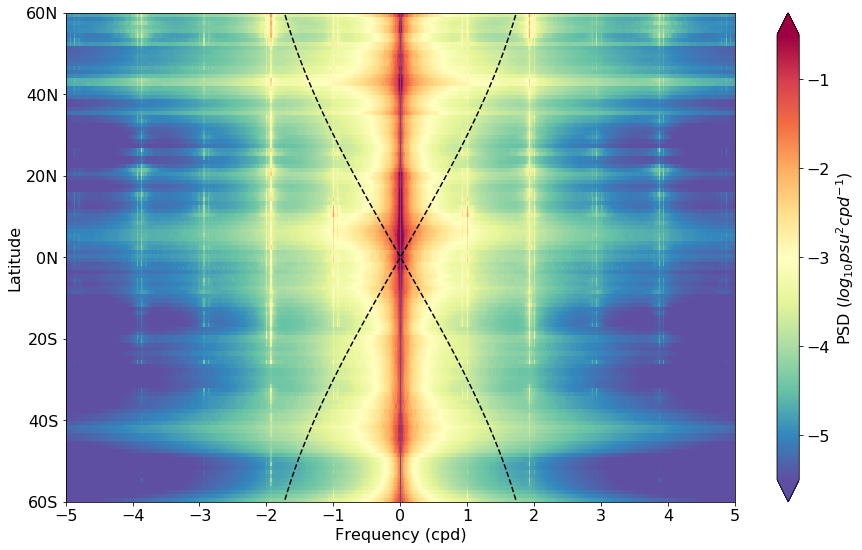

In [13]:

plt.figure(figsize=(15,9))
ax = plt.subplot(1,1,1)

cax = np.log10(E).plot.pcolormesh(ax=ax, vmin=-5.5, vmax=-0.5, x='freq_cpd', y='lat', cmap = 'Spectral_r', add_colorbar = False)

# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('PSD ($log_{10} psu^2 cpd^{-1})$', fontsize=16)


# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])

ax.set_ylabel('Latitude',fontsize=16)
ax.set_xlabel('Frequency (cpd)',fontsize=16)
ax.tick_params(labelsize=16)

# add coriolis frequency
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.lat))
ax.plot(f*86400./2./np.pi,f.lat,'k--')
ax.plot(-f*86400./2./np.pi,f.lat,'k--')

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Spectra_SSS_face0-12.png')



# Spatial variablity

In [6]:
face = 5

file_E = E_dir+'E_SSS_f%02d.nc'%face    
ds = xr.open_dataset(file_E, chunks={'i': 10, 'j': 432})
ds = ds.assign_coords(freq_cpd=ds.freq_time * 86400.)
print(ds)

<xarray.Dataset>
Dimensions:            (freq_time: 1440, i: 4320, j: 4320)
Coordinates:
  * i                  (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                  (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 ...
    face               int64 ...
    XC                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(10, 432)>
    YC                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(10, 432)>
    rA                 (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(10, 432)>
    Depth              (i, j) float32 dask.array<shape=(4320, 4320), chunksize=(10, 432)>
    freq_cpd           (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
Data variables:
    E                  (i, j, freq_time) float64 dask.array<shape=(4320, 4320, 1440), chunksize=(10, 432, 1440)>


In [7]:
print(ds.freq_cpd[120]) # 1 cpd

<xarray.DataArray 'freq_cpd' ()>
array(2.)
Coordinates:
    freq_time          float64 2.315e-05
    freq_time_spacing  float64 ...
    face               int64 ...
    freq_cpd           float64 2.0


In [8]:
eta = ds['E'].isel(freq_time=120, i=slice(2500,4320), j=slice(0,2000)).persist() # 2 cpd

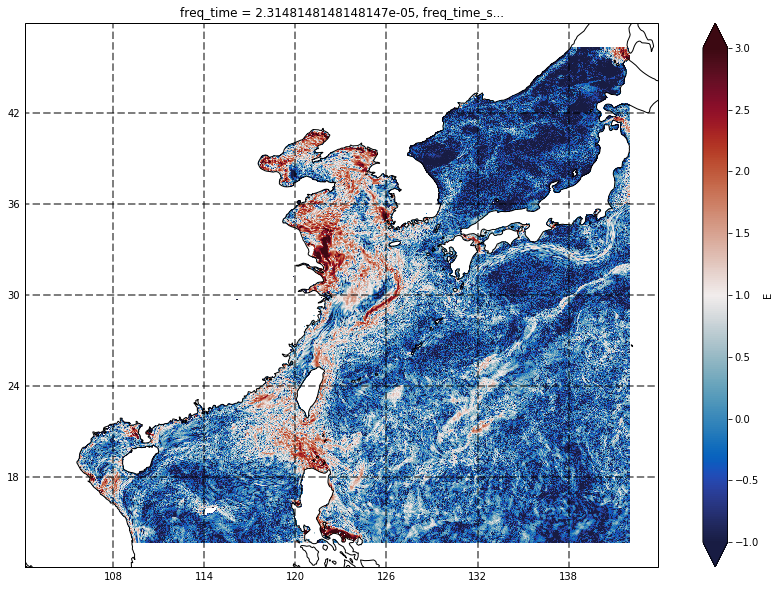

In [11]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
cax =  np.log10(eta).plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin = -1., vmax = 3., cmap = cm.balance)

gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

In [12]:
eta = ds['E'].isel(freq_time=60, i=slice(2500,4320), j=slice(0,2000)).persist() # 1 cpd

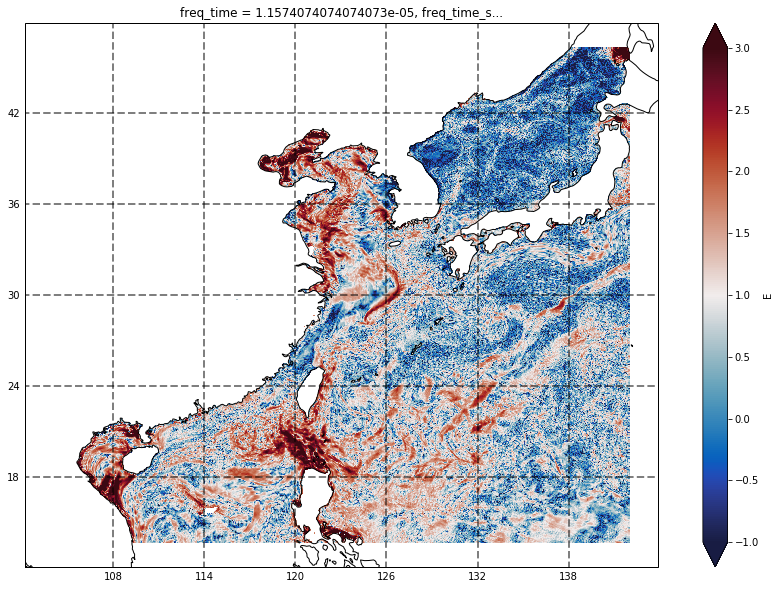

In [13]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
cax =  np.log10(eta).plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin = -1., vmax = 3., cmap = cm.balance)

gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

In [14]:
print(ds.freq_cpd[10]) # 1 cpd

<xarray.DataArray 'freq_cpd' ()>
array(0.166667)
Coordinates:
    freq_time          float64 1.929e-06
    freq_time_spacing  float64 ...
    face               int64 ...
    freq_cpd           float64 0.1667


In [15]:
eta = ds['E'].isel(freq_time=10, i=slice(2500,4320), j=slice(0,2000)).persist() # low frequency ~ 0.167 cpd

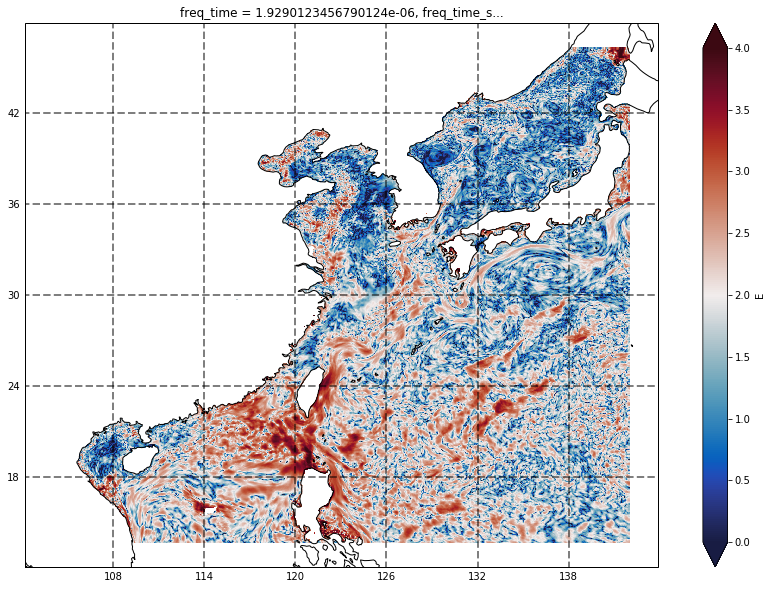

In [16]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
cax =  np.log10(eta).plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin = 0, vmax = 4, cmap = cm.balance)

gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

### Spatial average

In [17]:
%time E = ds['E'].mean(dim=('i','j')).load()

CPU times: user 2min 44s, sys: 6.91 s, total: 2min 51s
Wall time: 10min 59s


In [18]:
E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
print(E)

<xarray.DataArray 'E' (freq_time: 1440)>
array([1.090881e-04, 1.156365e+04, 6.816239e+03, ..., 3.570599e+03,
       6.816239e+03, 1.156365e+04])
Coordinates:
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 1.929e-07
    face               int64 5
    freq_cpd           (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...


In [19]:
E0 = E/1440*3600/86400 # unit --> ºC^2/cpd

E0 = E0.assign_coords(freq_time=E.freq_time * 86400.)
print(E0)

<xarray.DataArray 'E' (freq_time: 1440)>
array([3.156484e-09, 3.345963e-01, 1.972291e-01, ..., 1.033160e-01,
       1.972291e-01, 3.345963e-01])
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 1.929e-07
    face               int64 5
    freq_cpd           (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...


No handles with labels found to put in legend.


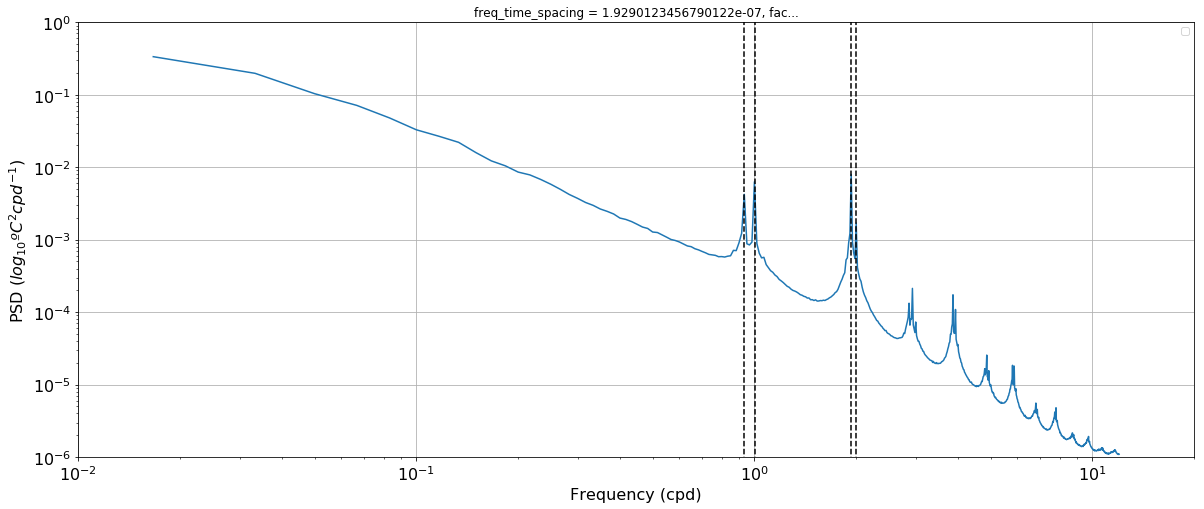

In [23]:
# SSU spectral plot


fig, ax = plt.subplots(figsize=(20,8))

E0.where(E0.freq_time>0).plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')

#ax.set_ylabel(''); 
ax.set_ylim([1e-6,1e0])
#ax.set_xlim([1e-5,1*1e-4])
ax.set_xlim([1e-2,2*1e1])

# Semi-diurnal frequencies#
ax.plot([24/12.42,24/12.42],[1e-7,1e6],'k--') # M2
ax.plot([24/12.00,24/12.00],[1e-7,1e6],'k--')  # S2

# Diurnal frequencies#

ax.plot([24/23.93,24/23.93],[1e-7,1e6],'k--')      # K1
ax.plot([24/25.81,24/25.81],[1e-7,1e6],'k--') # O1


#ax.set_xlim(-5., 5.)
#ax.set_ylim(-60., 60.)
#ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])

ax.set_ylabel('PSD ($log_{10} ºC^2 cpd^{-1})$',fontsize=16)
ax.set_xlabel('Frequency (cpd)',fontsize=16)
ax.tick_params(labelsize=16)

No handles with labels found to put in legend.


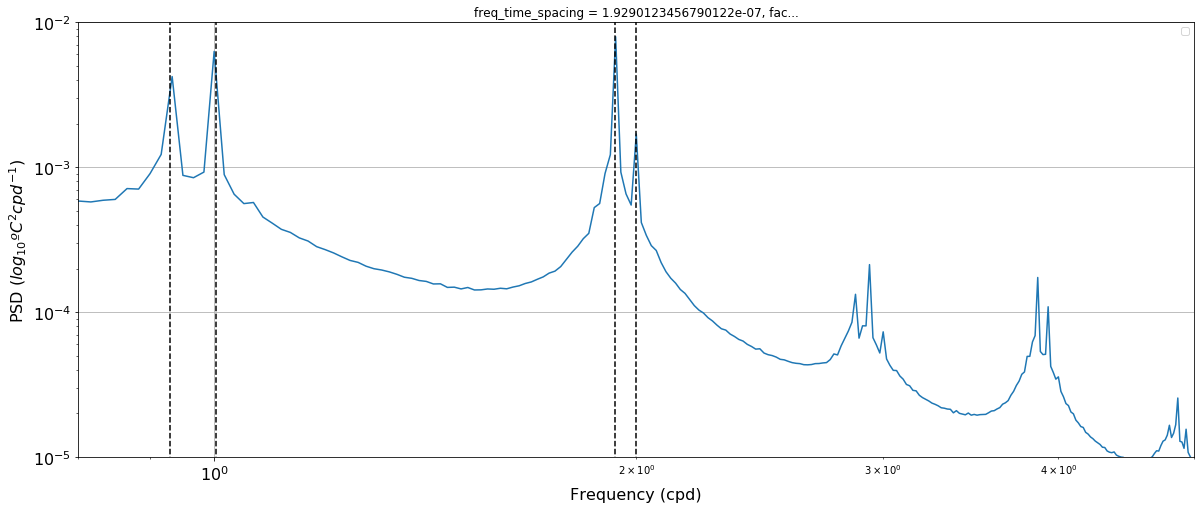

In [25]:


fig, ax = plt.subplots(figsize=(20,8))

E0.where(E0.freq_time>0).plot(ax=ax)
ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')

#ax.set_ylabel(''); 
ax.set_ylim([1e-5,1e-2])
#ax.set_xlim([1e-5,1*1e-4])
ax.set_xlim([8*1e-1,5*1e0])

# Semi-diurnal frequencies#
ax.plot([24/12.42,24/12.42],[1e-6,1e6],'k--') # M2

ax.plot([24/12.00,24/12.00],[1e-6,1e6],'k--')  # S2

# Diurnal frequencies#

ax.plot([24/23.93,24/23.93],[1e-6,1e6],'k--')      # K1
ax.plot([24/25.81,24/25.81],[1e-6,1e6],'k--') # O1


#ax.set_xlim(-5., 5.)
#ax.set_ylim(-60., 60.)
#ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0N','20N','40N','60N'])

ax.set_ylabel('PSD ($log_{10} ºC^2 cpd^{-1})$',fontsize=16)
ax.set_xlabel('Frequency (cpd)',fontsize=16)
ax.tick_params(labelsize=16)

---

In [14]:
cluster.scheduler.close()

<Future pending cb=[_make_coroutine_wrapper.<locals>.wrapper.<locals>.<lambda>() at /home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/tornado/gen.py:336]>

In [16]:
client.restart()

Client Scheduler: tcp://10.148.0.148:8786 Dashboard: http://10.148.0.148:8787/status,Cluster Workers: 15 Cores: 210 Memory: 1500.00 GB
